# Japan Network Analysis (Unified Pipeline)

Uses `src.analysis` + **Central Config** to calculate metrics.  
Exactly matches the Swiss Analysis structure.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..') 
sys.path.append('.')

import pickle
import networkx as nx
from pathlib import Path
from src.analysis.metrics import NetworkAnalyzer
from src.analysis.storage import ResultsManager
from src.analysis.visualizer import NetworkVisualizer
from src.analysis.config import AnalysisConfig

DEBUG: LOADING SRC.ANALYSIS.METRICS MODULE


In [2]:
COUNTRY = "japan"
GRAPH_PATH = AnalysisConfig.get_graph_path(COUNTRY)

NUM_SIMULATIONS = AnalysisConfig.NUM_RANDOM_SIMULATIONS
FRACTIONS = AnalysisConfig.FRACTIONS

print(f"Target Graph: {GRAPH_PATH}")
print(f"Random Simulations: {NUM_SIMULATIONS}")

Target Graph: datasets/japan/japan_rail_network.gpickle
Random Simulations: 50


In [3]:
if not Path(GRAPH_PATH).exists():
     print(f"Warning: {GRAPH_PATH} not found. Ensure you have run input processing.")
else:
    print(f"Loading {GRAPH_PATH}...")
    with open(GRAPH_PATH, 'rb') as f:
        G = pickle.load(f)
        
    analyzer = NetworkAnalyzer(G)
    storage = ResultsManager()
    viz = NetworkVisualizer()

Loading datasets/japan/japan_rail_network.gpickle...


NetworkVisualizer: CI environment detected. Interactive plots will be skipped to prevent build failures.


In [4]:
# 1. Global Metrics
if 'analyzer' in locals():
    global_metrics = storage.get_cached_or_run(
        COUNTRY,
        "global_metrics",
        lambda: analyzer.calculate_global_metrics()
    )
    print(global_metrics)

[global_metrics] Using cached results.
{'average_clustering_coefficient': 0.010920067027047812, 'average_path_length_topo': 71.94704359583523, 'global_efficiency': 0.017791000787040677, 'lcc_edges': 10327, 'lcc_nodes': 9698, 'local_efficiency': 0.011122177094466367, 'num_edges': 10952, 'num_nodes': 10357, 'average_degree': 2.114898136526021, 'diameter': 343}


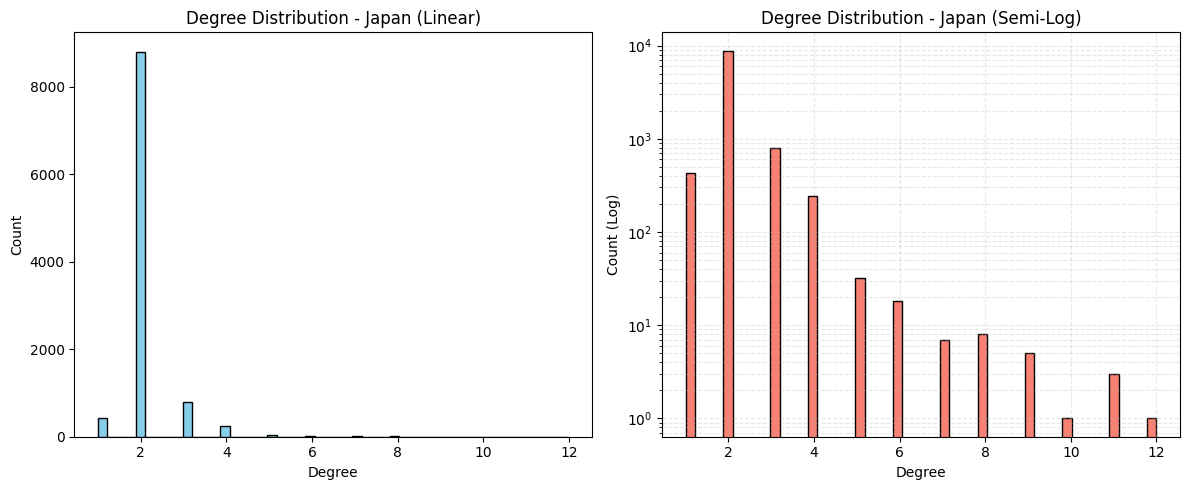

In [5]:
# Degree Distribution
if 'analyzer' in locals():
    viz.plot_degree_distribution(G, bins=50, title=f"Degree Distribution - {COUNTRY.title()}")

In [6]:
# 2. Robustness: Efficiency Decay
if 'analyzer' in locals():
    # 2.1 Random
    params_random = {'num_simulations': NUM_SIMULATIONS, 'fractions': FRACTIONS}
    random_eff = storage.get_cached_or_run(
        COUNTRY,
        "efficiency_decay_random",
        lambda: analyzer.simulate_random_attacks(FRACTIONS, NUM_SIMULATIONS),
        current_params=params_random
    )

    # 2.2 Targeted Degree
    targeted_deg = storage.get_cached_or_run(
        COUNTRY,
        "efficiency_decay_degree",
        lambda: analyzer.simulate_targeted_attack(FRACTIONS, strategy_name='degree')
    )
    
    # 2.3 Targeted Betweenness
    targeted_bet = storage.get_cached_or_run(
        COUNTRY,
        "efficiency_decay_betweenness",
        lambda: analyzer.simulate_targeted_attack(FRACTIONS, strategy_name='betweenness')
    )

    # 2.4 Targeted Inverse Degree
    targeted_inv_deg = storage.get_cached_or_run(
        COUNTRY,
        "efficiency_decay_inverse_degree",
        lambda: analyzer.simulate_targeted_attack(FRACTIONS, strategy_name='inverse_degree')
    )

    # 2.5 Targeted Inverse Betweenness
    targeted_inv_bet = storage.get_cached_or_run(
        COUNTRY,
        "efficiency_decay_inverse_betweenness",
        lambda: analyzer.simulate_targeted_attack(FRACTIONS, strategy_name='inverse_betweenness')
    )

    # 2.6 Targeted Articulation (LCC Minimization)
    targeted_art = storage.get_cached_or_run(
        COUNTRY,
        "efficiency_decay_articulation",
        lambda: analyzer.simulate_targeted_attack(FRACTIONS, strategy_name='articulation')
    )

[efficiency_decay_random] Cached data sufficient (50 runs >= 50). Using cache.
[efficiency_decay_degree] Using cached results.
[efficiency_decay_betweenness] Using cached results.
[efficiency_decay_inverse_degree] Using cached results.
[efficiency_decay_inverse_betweenness] Using cached results.
[efficiency_decay_articulation] Using cached results.


NetworkVisualizer: CI environment detected. Generating static plot for GitHub compatibility.


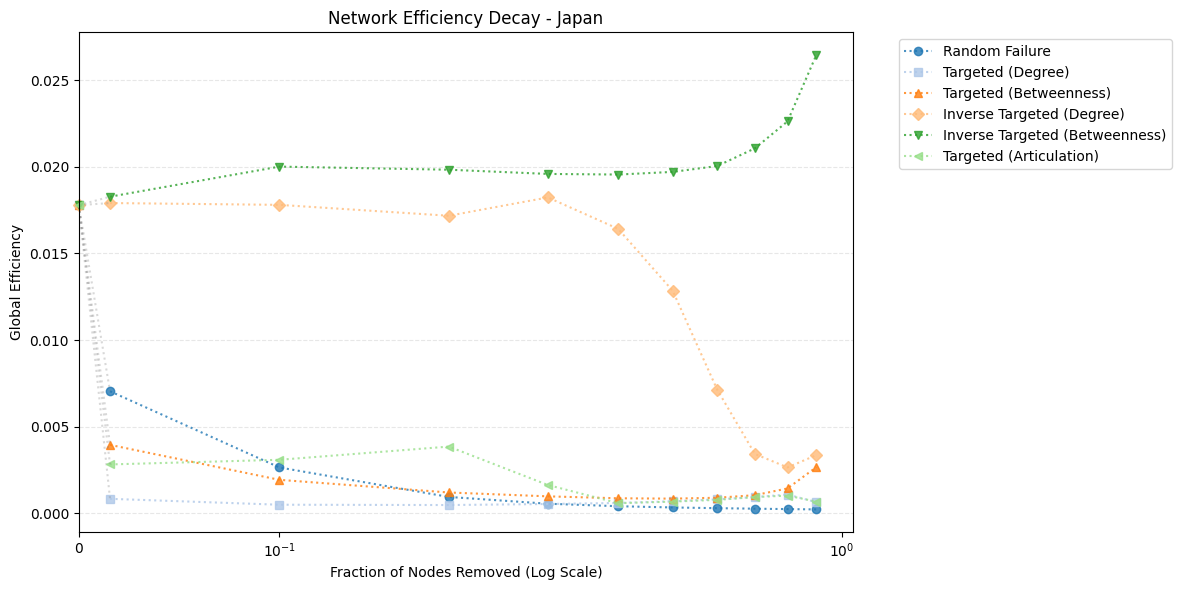

In [7]:
if 'viz' in locals() and 'random_eff' in locals():
    viz.plot_efficiency_decay({
        'Random Failure': random_eff['efficiency'],
        'Targeted (Degree)': targeted_deg,
        'Targeted (Betweenness)': targeted_bet,
        'Inverse Targeted (Degree)': targeted_inv_deg,
        'Inverse Targeted (Betweenness)': targeted_inv_bet,
        'Targeted (Articulation)': targeted_art
    }, title=f"Network Efficiency Decay - {COUNTRY.title()}")

In [8]:
# 3. Robustness: Extended Metrics (All Strategies)
# Calculating Average Degree, Clustering, Diameter, Path Length for ALL strategies.
# Random simulations might be time-consuming due to Diameter/Path Length calculations.

print("Running Extended Metrics Analysis for ALL Strategies...")
full_metrics = ['average_degree', 'clustering', 'diameter', 'avg_path_length', 'efficiency', 'lcc']

if 'analyzer' in locals():
    # 1. Random
    print("  - Random (this may take time)...")
    results_random = storage.get_cached_or_run(
        COUNTRY,
        "extended_metrics_random",
        lambda: analyzer.simulate_random_attacks(FRACTIONS, NUM_SIMULATIONS, metrics=full_metrics)
    )

    # 2. Targeted Strategies
    target_strategies = [
        ('degree', 'Targeted (Degree)'),
        ('betweenness', 'Targeted (Betweenness)'),
        ('inverse_degree', 'Inverse Targeted (Degree)'),
        ('inverse_betweenness', 'Inverse Targeted (Betweenness)'),
        ('articulation', 'Targeted (Articulation)')
    ]

    results_targeted = {}
    for strat, label in target_strategies:
        print(f"  - {label}...")
        results_targeted[strat] = storage.get_cached_or_run(
            COUNTRY,
            f"extended_metrics_{strat}",
            lambda: analyzer.simulate_targeted_attack(FRACTIONS, strategy_name=strat, metrics=full_metrics)
        )


Running Extended Metrics Analysis for ALL Strategies...
  - Random (this may take time)...


[extended_metrics_random] Using cached results.
  - Targeted (Degree)...
[extended_metrics_degree] Using cached results.
  - Targeted (Betweenness)...
[extended_metrics_betweenness] Using cached results.
  - Inverse Targeted (Degree)...
[extended_metrics_inverse_degree] Using cached results.
  - Inverse Targeted (Betweenness)...
[extended_metrics_inverse_betweenness] Using cached results.
  - Targeted (Articulation)...
[extended_metrics_articulation] Using cached results.


NetworkVisualizer: CI environment detected. Generating static plot for GitHub compatibility.


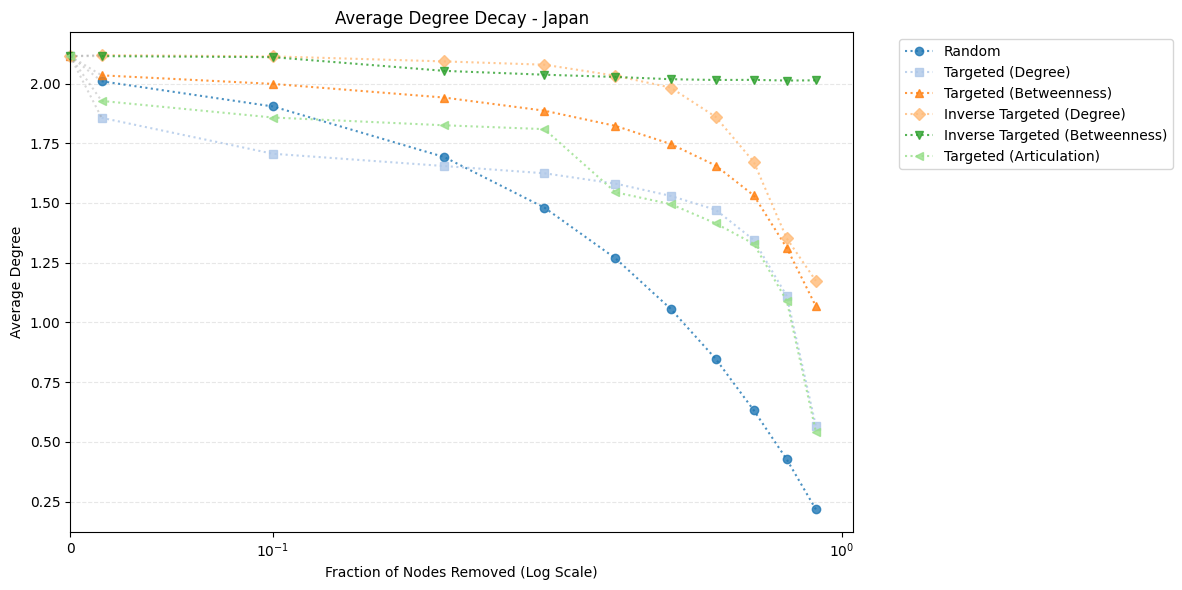

In [9]:
# Plot Average Degree Decay
if 'viz' in locals() and 'results_random' in locals():
    plot_data = { 'Random': results_random['average_degree'] }
    for strat, label in target_strategies:
        if strat in results_targeted:
            plot_data[label] = results_targeted[strat]['average_degree']

    viz.plot_metric_decay(plot_data, title=f"Average Degree Decay - {COUNTRY.title()}", ylabel="Average Degree", log_x=True)


NetworkVisualizer: CI environment detected. Generating static plot for GitHub compatibility.


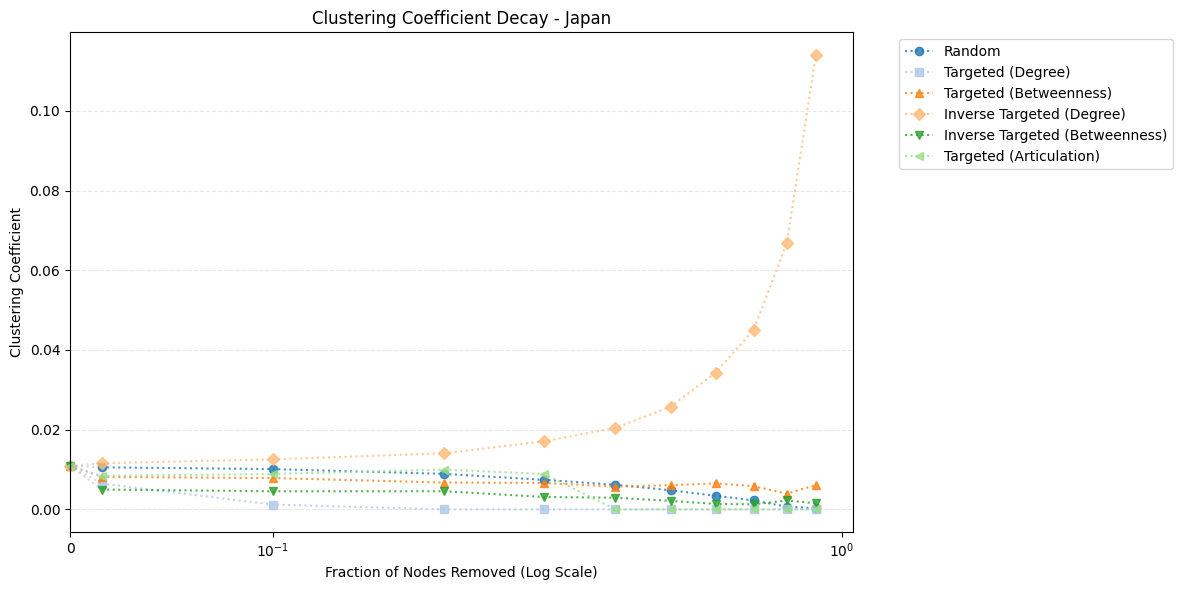

In [10]:
# Plot Clustering Coefficient Decay
if 'viz' in locals() and 'results_random' in locals():
    plot_data = { 'Random': results_random['clustering'] }
    for strat, label in target_strategies:
        if strat in results_targeted:
            plot_data[label] = results_targeted[strat]['clustering']

    viz.plot_metric_decay(plot_data, title=f"Clustering Coefficient Decay - {COUNTRY.title()}", ylabel="Clustering Coefficient", log_x=True)


NetworkVisualizer: CI environment detected. Generating static plot for GitHub compatibility.


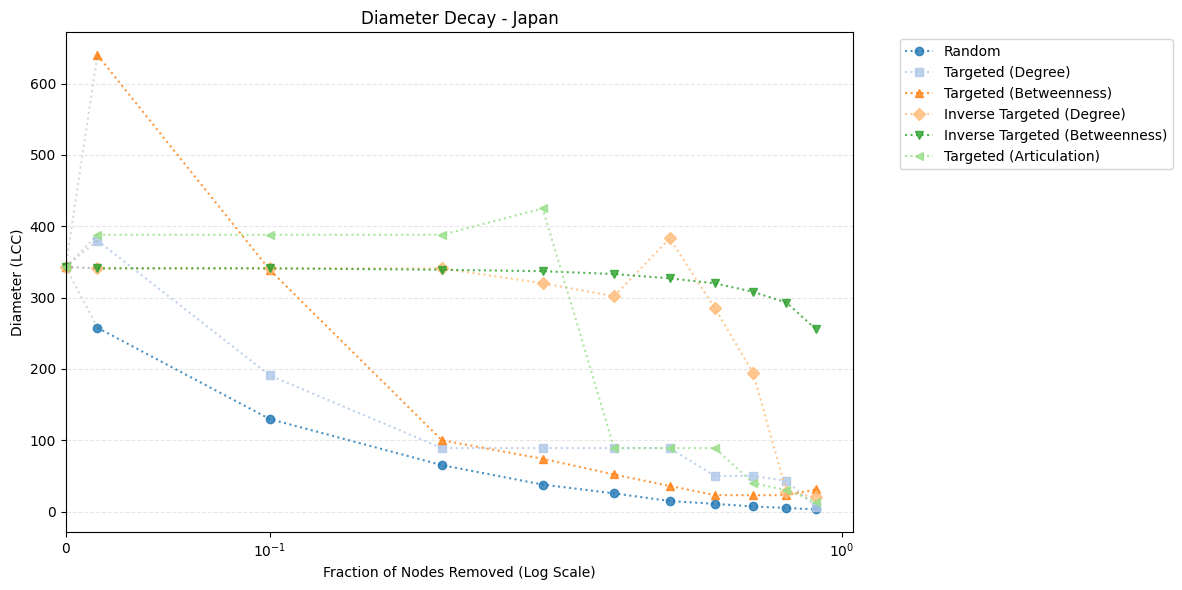

In [11]:
# Plot Diameter Decay
if 'viz' in locals() and 'results_random' in locals():
    plot_data = { 'Random': results_random['diameter'] }
    for strat, label in target_strategies:
        if strat in results_targeted:
            plot_data[label] = results_targeted[strat]['diameter']

    viz.plot_metric_decay(plot_data, title=f"Diameter Decay - {COUNTRY.title()}", ylabel="Diameter (LCC)", log_x=True)


NetworkVisualizer: CI environment detected. Generating static plot for GitHub compatibility.


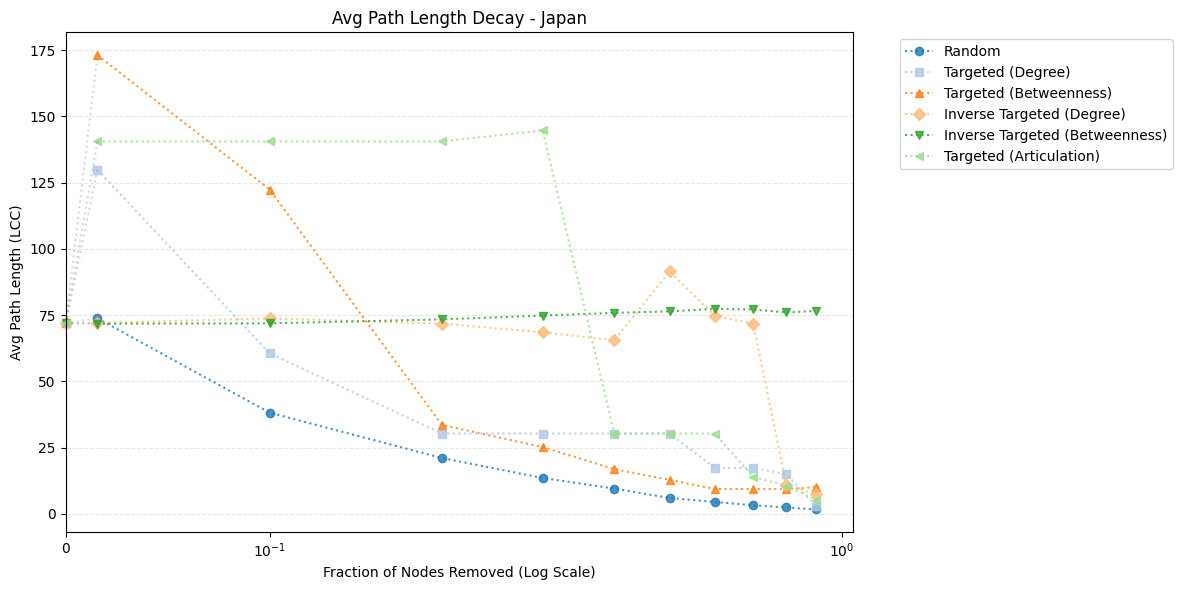

In [12]:
# Plot Avg Path Length Decay
if 'viz' in locals() and 'results_random' in locals():
    plot_data = { 'Random': results_random['avg_path_length'] }
    for strat, label in target_strategies:
        if strat in results_targeted:
            plot_data[label] = results_targeted[strat]['avg_path_length']

    viz.plot_metric_decay(plot_data, title=f"Avg Path Length Decay - {COUNTRY.title()}", ylabel="Avg Path Length (LCC)", log_x=True)


NetworkVisualizer: CI environment detected. Generating static map for GitHub compatibility.
Generating static Matplotlib map for: Initial State (CI Fallback)


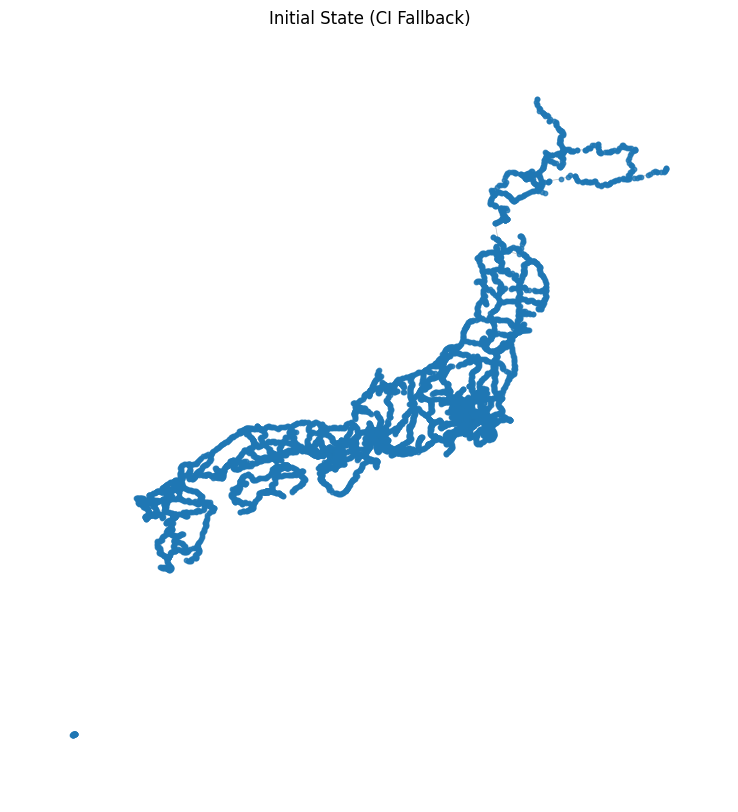

In [13]:
# Map visual (Interactive)
if 'viz' in locals():
    viz.create_interactive_map_ui(G)